In [1]:
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import seaborn as sns

In [2]:
df = pd.read_csv('../data/stock_teq.csv', index_col='date', parse_dates=True).sort_index()
df

,upper_alert_closed_adj,upper_alert_volume,lower_alert_closed_adj,lower_alert_volume,code,price,closed_adj_stage,price_stage_second,volume_stage
date,,,,,,,,,
2018-04-23,1.0,0.0,0.0,0.0,8628.0,1030.0,5,False,4
2018-04-23,0.0,0.0,0.0,0.0,4921.0,2017.5,1,False,1
2018-04-23,0.0,0.0,0.0,0.0,7561.0,1059.0,4,False,1
2018-04-23,0.0,0.0,0.0,0.0,6205.0,1140.0,5,False,4
2018-04-23,0.0,0.0,0.0,0.0,4274.0,973.0,4,False,4
...,...,...,...,...,...,...,...,...,...
2020-07-22,0.0,0.0,0.0,0.0,8986.0,105200.0,1,True,4
2020-07-22,0.0,0.0,0.0,0.0,2323.0,377.0,1,True,4
2020-07-22,0.0,0.0,0.0,0.0,1766.0,7110.0,4,True,4


In [3]:
# makeSign

def get_moving_statas(x):
    if x[0]==4 and x[1]==5 and x[2]==5:
        return 5
    elif x[1]==1 and x[2]==2:
        return 2
    else:
        return 0

def make_sign(df):
    signs = []

    for code in tqdm(df.code.unique()):
        df_picked = df.loc[df.code==code, :]

        # status変化をラベル変換
        moving_status = df_picked.closed_adj_stage.rolling(3).apply(
            lambda x: get_moving_statas(x))

        # ステージが5に変化したタイミングで購入する
        df_picked['purchase_sign'] = moving_status == 5
        # ステージが2に変化したタイミングで売る
        df_picked['selling_sign'] = moving_status == 2

        # 購入時の株数 (10万円以下の場合、10万に近くなるまで単元を増やす)
        df_picked['num_stock'] = df_picked.apply(lambda x: int(100000/x.price) if x.purchase_sign and x.price <= 1000 else 100, axis=1)

        signs.append(df_picked[['code', 'price', 'purchase_sign', 'selling_sign', 'num_stock']])
    
    return pd.concat(signs, axis=0)

df_sign = make_sign(df)

In [4]:
import numpy as np
from scipy.stats import skew

class BackTest:
    def __init__(self, songiri_flag=False):
        self.balance = 0
        self.num_stock = 0
        self.price = 0
        self.songiri_flag = songiri_flag
        
    def start(self, prices: list, purchase_signs: list, selling_signs: list, num_stocks: list):
        if not self.__is_equal_size(prices, purchase_signs, selling_signs, num_stocks):
            print('Invalid array size.')
        
        for price, purchase, selling, num_stock in zip(prices, purchase_signs, selling_signs, num_stocks):
            if int(purchase)==1:
                self.price = int((self.price*self.num_stock + price*num_stock)/(self.num_stock+num_stock))
                self.num_stock += num_stock
                #print(f"購入：{price}円 平均株価：{self.price} 株式数：{self.num_stock} 合計金額：{self.price*self.num_stock}")
            
            if int(selling)==1 and self.__is_higher_purchase_price(price) and self.num_stock > 0:
                self.balance += self.num_stock*(price-self.price)
                #print(f"売却：{self.num_stock*price}円 残高：{self.balance}")
                self.num_stock = 0
                self.price = 0

        return self.balance + self.num_stock*(price-self.price)

    def __is_equal_size(self, price_signs: list, purchase_signs: list, selling_signs: list, num_stocks: list):
        return len(price_signs) and len(purchase_signs) and len(selling_signs) and len(num_stocks)

    def __is_higher_purchase_price(self, price):
        if not self.songiri_flag:
            return self.price >= price
        
        return True

def run_back_test():
    balances = []

    for code in tqdm(df_sign.code.unique()):

        price = df_sign[df_sign.code==code].price.tolist()
        purchase_sign = df_sign[df_sign.code==code].purchase_sign.tolist()
        selling_sign = df_sign[df_sign.code==code].selling_sign.tolist()
        num_stock = df_sign[df_sign.code==code].num_stock.tolist()

        backtest = BackTest(songiri_flag=True)
        balance = backtest.start(price, purchase_sign, selling_sign, num_stock)
        balances.append((code, balance))

    profit = [balance[1] for balance in balances]
    print(f"中央値：{np.median(profit)}、歪度：{skew(profit)}")
    return balances

balances = run_back_test()


中央値：8000.0、歪度：7.522925515083015


In [5]:
pd.DataFrame(balances, columns=('code', 'profit')).to_csv('../data/stock_profit.csv', index=None)

## シミュレート結果
1. ステータス変化の検知 & 1日目にイン & 1000未満の単元は1000円近くまで単元を増やす & 損切りあり
    - median
        - 4700
    - skew
        - -0.707

2. ステータス変化の検知 & 2日目にイン & 1000未満の単元は1000円近くまで単元を増やす & 損切りあり
    - median
        - 6900
    - skew
        - 7.403

<AxesSubplot:ylabel='Frequency'>

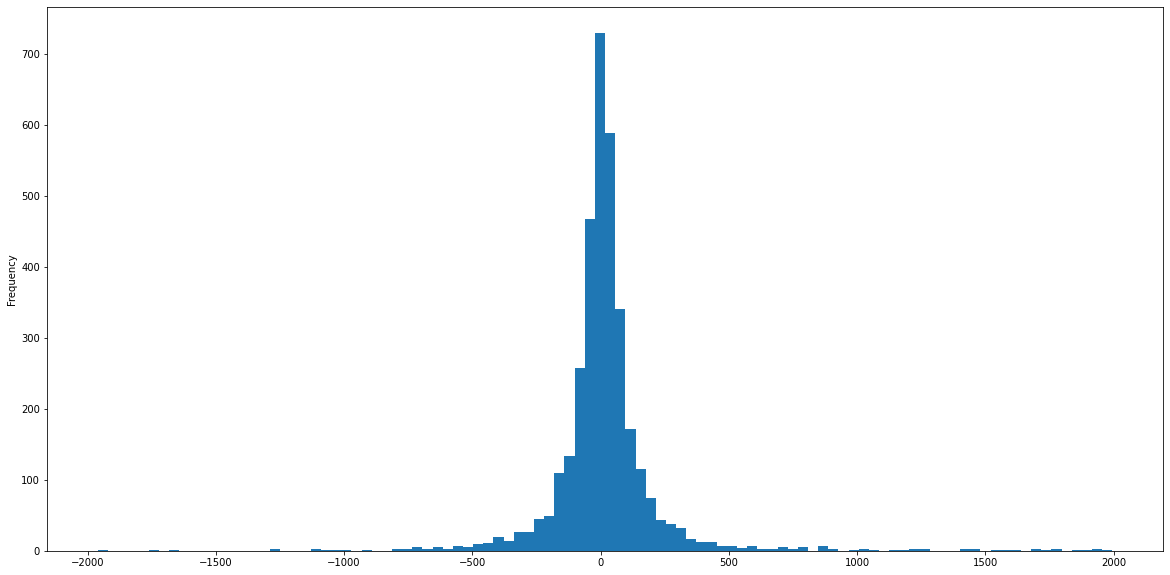

In [406]:
import matplotlib.pyplot as plt

s = pd.Series([balance[1] for balance in balances])/1000

plt.figure(figsize=(20.0, 10.0))
s[s.between(-2000, 2000)].plot(kind='hist', bins=100)